Gregory Moore and Babita Giri
<br> CHEM E 545 Final Project
<br> November 27th 2023

**Material Classification for clean energy applications** <br>
New materials need to be synthezied and characterized for improving existing clean energy applications. Your task is to predict the material classes based on thier given molecular properties. Your goal in this project to think like a data scientist and to achieve highest accuracy of classification.
You have been provided with two excel files. First file contains the molecular properties of the materials. Second file lists the classes of the material. Do data preprocessing if necessary at any step, always use a random seed wherever you can and describe your methods and results in detail. All plots should have labels and legends. 
Complete the tasks below (100 points):


1.   **Data Visualization and Unsupervised Classification** : Visualize the data and implement PCA and K-means to see if you can separate different classes. Report your findings. (10)

In [19]:
#Import the necessary packages, install Scikeras package to the cloud environment with Pip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikeras
!pip install xgboost

  Using cached xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [2]:
#Read in the features and target variables and use pd.concat to combine them side by side into one dataframe
features = pd.read_csv('features.csv')
target = pd.read_csv('target.csv')
df = pd.concat([features, target], axis=1, ignore_index = False)

In [3]:
#Apply standard scaler to all the numerical columns. This is important to do because some columns like Unit Volume have values in the hundreds or thousands
#while other columns like deltaE are less than 1. We scale everything so that we get a more accurate idea of what is contributing to the variance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[['deltaE_Hull(eV)','Num_atoms','DeltaE(eV)','Formation Energy (eV)',
    'Material Density(gm/cc)','Unit Volume ']] = scaler.fit_transform(df[['deltaE_Hull(eV)','Num_atoms','DeltaE(eV)','Formation Energy (eV)',
                                                                          'Material Density(gm/cc)','Unit Volume ']])
#Define X as all of the features, and Y as the target variable 
X = scaled_df.drop('Type of Material',axis=1)
Y = scaled_df['Type of Material']
X

,deltaE_Hull(eV),Num_atoms,Band Presence,DeltaE(eV),Formation Energy (eV),Material Density(gm/cc),Unit Volume,symmetry group
0,1.304751,-0.469187,1,-0.997463,0.201550,0.920356,-0.537601,16
1,0.186233,-1.075274,1,-0.654982,1.385445,-0.087381,-0.994342,31
2,0.067274,3.167334,0,-0.738838,1.333977,-0.001037,3.191852,6
3,-1.557088,-0.469187,1,1.228896,-0.560459,-0.510388,-0.580288,6
4,0.872143,-0.469187,1,0.992021,-0.883511,-0.629818,-0.435311,20
...,...,...,...,...,...,...,...,...
334,-1.159219,0.742986,1,0.819281,0.153941,-0.303661,0.837238,27
335,0.058672,-0.382604,1,-0.684281,0.340672,0.118602,-0.412423,20
336,-0.373138,0.569819,1,0.686469,0.701847,0.993534,0.443625,21
337,-0.993531,1.046030,0,-1.627953,2.343274,3.163101,0.434385,16


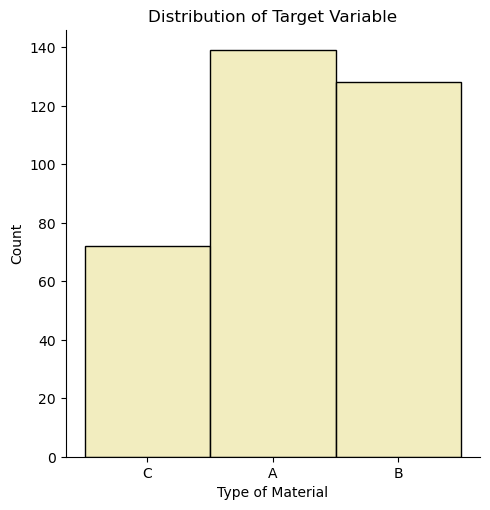

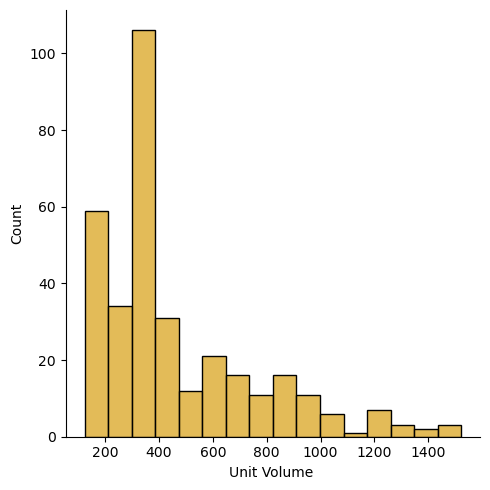

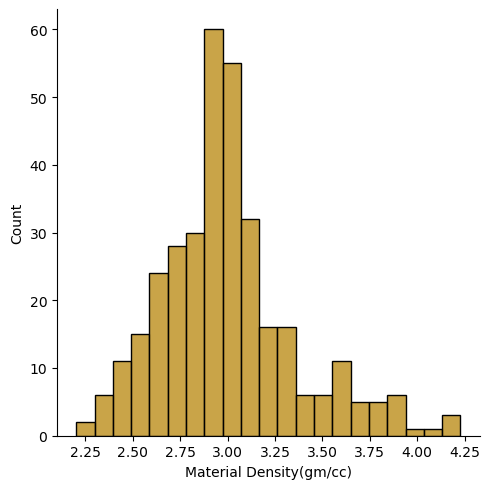

In [4]:
#Plot the distribution of the target variable
sns.displot(Y, color='palegoldenrod')
plt.title("Distribution of Target Variable")
#Next, checking the distribution of a few of the features to get a better understanding of the feature space

#Distribution of unit volume feature 
sns.displot(df['Unit Volume '], color='goldenrod')
#Distribution of material density feature
sns.displot(df['Material Density(gm/cc)'],color='darkgoldenrod')

It is important to visualize the distribution of the target variable to understand our data. 
If, for example, the target variable distribution overwhelmingly favored A and there were very few B or C, then that would inform us that using "accuracy" score may not be the best option because is those scenarios the most "accurate" model could just be the one that predicts A all the time.

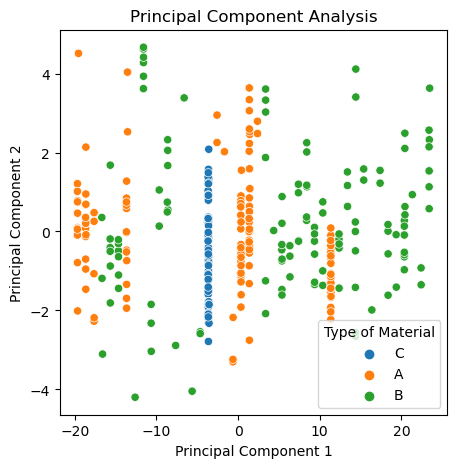

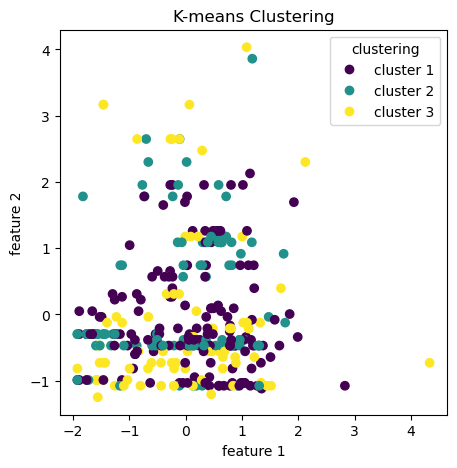

In [6]:
from sklearn.decomposition import PCA 
import seaborn as sns

#Apply Principal Component Analysis to the feature space
pca = PCA(n_components = 2, random_state=42)
X_pca = pca.fit_transform(X)

#Plot the principal component analysis cluster plot
plt.figure(figsize=(5,5))
plt.title('Principal Component Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
sns.scatterplot(x = X_pca[:, 0],y= X_pca[:, 1], hue=Y)

#Apply Kmeans clustering to the feature space, set the number of clusters to 3 since we know there are three types of materials; A,B,C.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
y_pred_kmeans = kmeans.fit_predict(X)

# Plot K-means cluster plot
plt.figure(figsize=(5,5))
scatter=plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y_pred_kmeans)
plt.title('K-means Clustering')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(handles = scatter.legend_elements()[0], labels=['cluster 1','cluster 2','cluster 3'],title="clustering")

From the PCA and KMeans cluster plots it appears that neither classifier is effective at separating the material classes from one another.

2.   **Classification of materials**: Implement Decision tree classifier, Random Forest (RF) and KNN classifier on the dataset and estimate the accuracies, F-1 score and confusion matrix. Report which classifier performs the best. Also use the features from the pca and k-means implementation in (1) to see if that improves the classification results. (20)

In [8]:
#Decision Tree Classifier 
# Define the evaluate_classifier function
def evaluate_classifier(X_train, X_test, y_train, y_test, y_pred, clf_model, model_name):
    print('Printing results for model: ' + str(model_name))
    print('Accuracy on training {:.3f}'.format(clf_model.score(X_train, y_train)))
    print('Accuracy on test {:.3f}'.format(clf_model.score(X_test, y_test)))
    print('F1 score {:.3f}'.format(f1_score(y_test,y_pred,average='weighted')))
    print(confusion_matrix(y_test,y_pred))
    print()
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#Decision Tree Classifier on entire dataset
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
evaluate_classifier(X_train, X_test, y_train, y_test, y_pred, dt, 'Decision Tree on entire dataset')

#Decision tree classifier on PCA features
dt_pca = DecisionTreeClassifier(random_state=42)
dt_pca.fit(X_train_pca, y_train_pca)
y_pred_dt_pca = dt_pca.predict(X_test_pca)
evaluate_classifier(X_train_pca, X_test_pca, y_train_pca, y_test_pca, y_pred_dt_pca, dt_pca, 'Decision tree on PCA features')

Printing results for model: Decision Tree on entire dataset
Accuracy on training 1.000
Accuracy on test 0.971
F1 score 0.971
[[25  0  0]
 [ 0 31  2]
 [ 0  0 10]]

Printing results for model: Decision tree on PCA features
Accuracy on training 1.000
Accuracy on test 0.971
F1 score 0.971
[[25  0  0]
 [ 0 31  2]
 [ 0  0 10]]



The decision tree classifier got an accuracy of 0.971 when applied on the entire feature space, and got the same 0.971 accuracy when applied on the features from PCA. 

In [9]:
#Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
evaluate_classifier(X_train, X_test, y_train, y_test, y_pred, rf_clf, 'Random Forest on entire dataset')

#Random Forest Classifier on PCA Features 
rf_clf_pca = RandomForestClassifier(random_state=42)
rf_clf_pca.fit(X_train_pca, y_train_pca)
y_pred_rf_clf_pca = rf_clf_pca.predict(X_test_pca)
evaluate_classifier(X_train_pca, X_test_pca, y_train_pca, y_test_pca, y_pred_rf_clf_pca, rf_clf_pca, 'Random forest on PCA features')

Printing results for model: Random Forest on entire dataset
Accuracy on training 1.000
Accuracy on test 0.912
F1 score 0.911
[[25  0  0]
 [ 4 27  2]
 [ 0  0 10]]

Printing results for model: Random forest on PCA features
Accuracy on training 1.000
Accuracy on test 0.941
F1 score 0.941
[[25  0  0]
 [ 2 29  2]
 [ 0  0 10]]



The random forest classifier got an accuracy of 0.911 when applied on the entire feature space, but when the random forest was applied on the features from PCA implementation the classification accuracy increased to 0.941, and there were fewer misclassifications on the confusion matrix.

In [10]:
#K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)
evaluate_classifier(X_train, X_test, y_train, y_test, y_pred, knn_clf, 'KNN on entire dataset')

#K Neighbors Classifier on PCA features
knn_clf_pca = KNeighborsClassifier()
knn_clf_pca.fit(X_train_pca, y_train_pca)
y_pred_knn_pca = knn_clf_pca.predict(X_test_pca)
evaluate_classifier(X_train_pca, X_test_pca, y_train_pca, y_test_pca, y_pred_knn_pca, knn_clf_pca, 'KNN on PCA features')

Printing results for model: KNN on entire dataset
Accuracy on training 0.963
Accuracy on test 0.926
F1 score 0.930
[[23  1  1]
 [ 0 30  3]
 [ 0  0 10]]

Printing results for model: KNN on PCA features
Accuracy on training 0.978
Accuracy on test 0.926
F1 score 0.930
[[23  1  1]
 [ 0 30  3]
 [ 0  0 10]]



The K Nearest Neighbors classifieer had a test accuracy of 0.926 when implemented on the entire feature space, and also got 0.926 test accuracy when applied on the features from PCA implementation.

Out of the three classification algorithms tested in this problem, the Decision Tree classifier performed the best with an accuracy score on the testing data of 0.971. 

3.   **Hyper-parameter tuning**: Implement hyperparameter tuning on random forest and KNN algorithms. Report the best performing model and the respective hyperparameters with highest accuracy. (20)


In [11]:
#Implementing hyperparameter tuning on the Random Forest model.
from sklearn.model_selection import GridSearchCV

#First establish the dictionary object for the grid of parameters we wish to search
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Apply the gridsearchCV function and fit it to our training data
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid_rf, cv=5, scoring='accuracy',
                             verbose=1)
grid_search_rf.fit(X_train,y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [12]:
best_model_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_model_rf.predict(X_test)
print("Best Parameters for Random Forest are " +str(grid_search_rf.best_params_))
print("\nBest random forest model was " + str(grid_search_rf.best_estimator_))
print("\nAccuracy: " + str(accuracy_score(y_test,y_pred_best_rf)))

Best Parameters for Random Forest are {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

Best random forest model was RandomForestClassifier(min_samples_split=5, n_estimators=150, random_state=42)

Accuracy: 0.9117647058823529


In [13]:
#Hyperparameter Tuning for KNN Algorithm
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy',
                              verbose=1)
grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [14]:
best_model_knn = grid_search_knn.best_estimator_
y_pred_best_knn = best_model_knn.predict(X_test)
print("\nBest Parameters for KNN are " +str(grid_search_knn.best_params_))
print("\nBest KNN was " + str(grid_search_knn.best_estimator_))
print("\nAccuracy: " + str(accuracy_score(y_test,y_pred_best_knn)))


Best Parameters for KNN are {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Best KNN was KNeighborsClassifier(n_neighbors=3, weights='distance')

Accuracy: 0.9411764705882353


The best performing model after hyperparameter tuning was the K nearest neighbors model with n_neighbors = 3, p=2, and "weights" = "distance" and got an accuracy of 0.941. This tuned KNN model performed better than the random forest classifier.

4. **Most important features**: Not all features contribute to the classification accuracy equally. Estimate the order of best performing features. Repeat the classification task with including different number of features in your RF classifier and report how accuracy is changing (10)

In [35]:
# Feature Importance Analysis for Random Forest
feature_importances = best_model_rf.feature_importances_

# Sort features by their importance in descending order
sorted_feature_indices = feature_importances.argsort()[::-1]

# Display feature importance scores and corresponding feature names
print("\nFeature Importance Scores:")
for i, feature_index in enumerate(sorted_feature_indices):
    print(f"{X.columns[feature_index]}: {feature_importances[feature_index]:.4f}")

# Repeat the classification task with different numbers of features
num_features_to_include = [1, 2, 3, 4, 5, 6, 7, 8]  # Changing this list based on total number of features

for num_features in num_features_to_include:
    # Select the top 'num_features' important features
    selected_features_indices = sorted_feature_indices[:num_features]
    
    # Train Random Forest classifier with selected features
    rf_classifier_selected_features = RandomForestClassifier(random_state=42)
    rf_classifier_selected_features.fit(X_train.iloc[:, selected_features_indices], y_train)

    # Evaluate the classifier on the test set
    y_pred_rf_selected_features = rf_classifier_selected_features.predict(X_test.iloc[:, selected_features_indices])
    accuracy_rf_selected_features = accuracy_score(y_test, y_pred_rf_selected_features)

    # Report the results
    print(f"\nResults for Random Forest with {num_features} features:")
    print(f"Selected Features: {X.columns[selected_features_indices].tolist()}")
    print(f"Accuracy: {accuracy_rf_selected_features:.3f}")




Feature Importance Scores:
symmetry group: 0.4005
Unit Volume : 0.1323
DeltaE(eV): 0.1007
Formation Energy (eV): 0.0970
Num_atoms: 0.0920
Material Density(gm/cc): 0.0893
deltaE_Hull(eV): 0.0790
Band Presence : 0.0091

Results for Random Forest with 1 features:
Selected Features: ['symmetry group']
Accuracy: 0.971

Results for Random Forest with 2 features:
Selected Features: ['symmetry group', 'Unit Volume ']
Accuracy: 0.971

Results for Random Forest with 3 features:
Selected Features: ['symmetry group', 'Unit Volume ', 'DeltaE(eV)']
Accuracy: 0.912

Results for Random Forest with 4 features:
Selected Features: ['symmetry group', 'Unit Volume ', 'DeltaE(eV)', 'Formation Energy (eV)']
Accuracy: 0.926

Results for Random Forest with 5 features:
Selected Features: ['symmetry group', 'Unit Volume ', 'DeltaE(eV)', 'Formation Energy (eV)', 'Num_atoms']
Accuracy: 0.941

Results for Random Forest with 6 features:
Selected Features: ['symmetry group', 'Unit Volume ', 'DeltaE(eV)', 'Formation 

In this problem, the order of features' importances were calculated. It was found that the symmetry group is the most important feature, with a feature weight of 40%. Using just the symmetry group alone the classification accuracy was 97%. The second most important feature was the Unit Volume. Applying random forest using just the two most important features gave a classification accuracy of 97%. Adding more features than the two most important features lowered the accuracy, indicating perhaps that the model was overfitting to the training data and could not generalize well to the test data.

5. **XGBoost** : XGBoost is a python ML library that uses optimized gradient boosted trees and has been really successful in completing many ML tasks. Implement XGBoost on the data. Perform hyper-parameter tuning and report the highest accuracy you acheive. (20)

In [20]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
#Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150]
}

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# XGBoost Classifier with Hyperparameter Tuning
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train_encoded)

# Get the best parameters and model
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate the best XGBoost model
y_pred_xgb_tuned = best_model_xgb.predict(X_test)
accuracy_xgb_tuned = accuracy_score(y_test_encoded, y_pred_xgb_tuned)

# Report the results
print("\nResults for XGBoost after Hyperparameter Tuning:")
print(f"Best Parameters: {best_params_xgb}")
print(f"Accuracy: {accuracy_xgb_tuned:.2f}")



Results for XGBoost after Hyperparameter Tuning:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 1.00


In this problem we created an Extreme Gradient Boosted (XGBoost) tree model to classify the material classes. The hyperparameters of the model were tuned using GridSearchCV with 5-fold cross validation. The parameters corresponding to the best model were reported above which gave an accuracy of 1.00. The XGBoost model is a very good predictor of the material classes.

6. **Neural Networks**: In the era of generative AI, which is powered by neural networks, lets see how neural nets perform compared to other ML classification models. Implement a neural network to predict the class (you can use keras, tensorflow or pytorch). Play with changing the number of layers and nodes per layers to see if you can increase the classification accuracy. (20)

In [23]:
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#Apply label encoding to y_train and y_test so that the output instead of A,B,C is [1,0,0] or [0,1,0] or [0,0,1]. 
y_train_onehot = to_categorical(label_encoder.fit_transform(y_train))
y_test_onehot = to_categorical(label_encoder.transform(y_test))

#Define a function to build the neural network
def nn_builder():
    #The model is built using Keras Sequential
    model = Sequential()
    #Input layer in the dimensions of the X train data
    model.add(Input(shape=X_train.shape[1]))
    #Two hidden layers with 8 output neurons each
    model.add(Dense(8,kernel_initializer='normal',activation='relu'))
    model.add(Dense(8,kernel_initializer='normal',activation='relu'))
    #output layer with softmax activation since we are getting predictions
    model.add(Dense(3,kernel_initializer='normal',activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    return model

nn_model = nn_builder()
nn_model.summary()

#Filter out the warning about Tensorflow being optimized to use CPU vs GPU 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 3)                 27        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Fit the neural network model to the training data over 30 epochs with a validation split of 20%
history = nn_model.fit(X_train,y_train_onehot,epochs=30, validation_split = 0.2,
                      verbose=0)

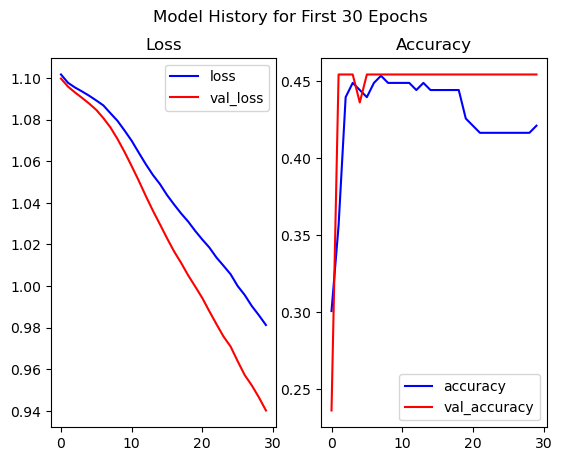

In [25]:
#Make a subplot showing the model history for the first 30 epochs
fig, axs = plt.subplots(1,2)
plt.suptitle('Model History for First 30 Epochs')

#In the first subplot compare the loss with validation loss
axs[0].plot(history.history['loss'],c='blue')
axs[0].plot(history.history['val_loss'], c='red')
axs[0].set_title('Loss')
axs[0].legend(['loss','val_loss'])

#In the second subplot compare the accuracy with the validation accuracy
axs[1].plot(history.history['accuracy'],c='blue')
axs[1].plot(history.history['val_accuracy'],c='red')
axs[1].set_title('Accuracy')
axs[1].legend(['accuracy','val_accuracy'])

In [26]:
#Neural Network Hyperparameter Tuning
#We will be tuning for the number of neurons in the first hidden layer, number of neurons in the second hidden layer,
#the activation function of the hidden layers, and the learning rate. 

#Define the function to build the NN and pass as parameters the hyperparameters we are going to be tuning.
def nn_builder(hidden1_neurons, hidden2_neurons, activation, learning_rate=0.01):
    model = Sequential()
    #Input layer in the dimensions of the X train data
    model.add(Input(shape=X_train.shape[1]))
    #Two hidden layers with 8 output neurons each
    model.add(Dense(hidden1_neurons,kernel_initializer='normal',activation=activation))
    model.add(Dense(hidden2_neurons,kernel_initializer='normal',activation=activation))
    #output layer with softmax activation since we are getting predictions
    model.add(Dense(3,kernel_initializer='normal',activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer="Adam",metrics=['accuracy'])
    return model

from scikeras.wrappers import KerasClassifier
classifier_search = KerasClassifier(nn_builder, learning_rate=0.01, 
                                    hidden1_neurons=8,hidden2_neurons=8,
                                   activation='relu')

#Parameter grid for the hyperparameters to be tuned
nn_parameters = {
    "learning_rate": [0.1,0.03,0.01,0.005],
    "hidden1_neurons" : [8,16,32,64],
    "hidden2_neurons" : [8,16,32,64],
    "activation" : ['relu','sigmoid'],
}

#Using randomized search cross validation to find the best hyperparameters. 
from sklearn.model_selection import RandomizedSearchCV
nn_rand_search = RandomizedSearchCV(classifier_search,param_distributions = nn_parameters,
                              cv=5, verbose=0, n_iter=20)

#Fitting the model to the training data over 30 epochs.
nn_rand_search.fit(X_train,y_train_onehot,epochs=30,
                    verbose=0)


2/2 [==============================] - 0s 4ms/step


RandomizedSearchCV(cv=5,
                   estimator=KerasClassifier(activation='relu', hidden1_neurons=8, hidden2_neurons=8, learning_rate=0.01, model=<function nn_builder at 0x7efc980c2950>),
                   n_iter=20,
                   param_distributions={'activation': ['relu', 'sigmoid'],
                                        'hidden1_neurons': [8, 16, 32, 64],
                                        'hidden2_neurons': [8, 16, 32, 64],
                                        'learning_rate': [0.1, 0.03, 0.01,
                                                          0.005]})

In [27]:
print("Best neural network hyperparameters were " + str(nn_rand_search.best_params_)) 

Best neural network hyperparameters were {'learning_rate': 0.03, 'hidden2_neurons': 64, 'hidden1_neurons': 64, 'activation': 'relu'}


In [30]:
#Build the model using the best hyperparameters and report its accuracy
best_model = nn_builder(64,64,"relu",learning_rate=0.03)
history2 = best_model.fit(X_train,y_train_onehot,epochs=100, validation_split = 0.2, verbose=0)

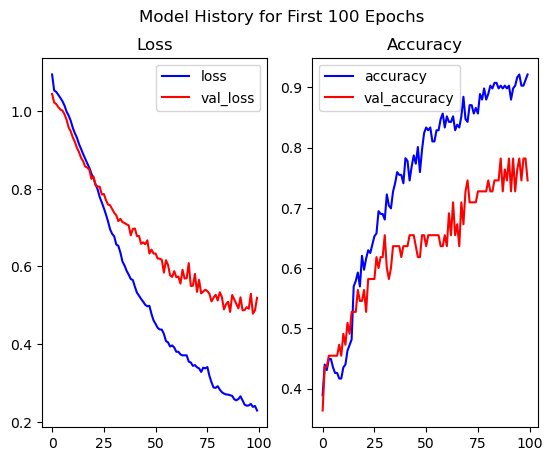

In [31]:
#Make a subplot showing the model history for the first 100 epochs
fig, axs = plt.subplots(1,2)
plt.suptitle('Model History for First 100 Epochs')

#In the first subplot compare the loss with validation loss
axs[0].plot(history2.history['loss'],c='blue')
axs[0].plot(history2.history['val_loss'], c='red')
axs[0].set_title('Loss')
axs[0].legend(['loss','val_loss'])

#In the second subplot compare the accuracy with the validation accuracy
axs[1].plot(history2.history['accuracy'],c='blue')
axs[1].plot(history2.history['val_accuracy'],c='red')
axs[1].set_title('Accuracy')
axs[1].legend(['accuracy','val_accuracy'])

From the hyperparameter tuning we see that the classification accuracy of the neural network improved by using the optimal hyperparameters we found using Randomized Search cross validation. 

**Cool things you can try doing if you want that won't be graded** <br>
1. Remove outliers to see if that improves the classification
2. Try out data visualization techniques that were not covered in the course
3. See if you implement transfer learning and hyperparameter tuning for your neural network model

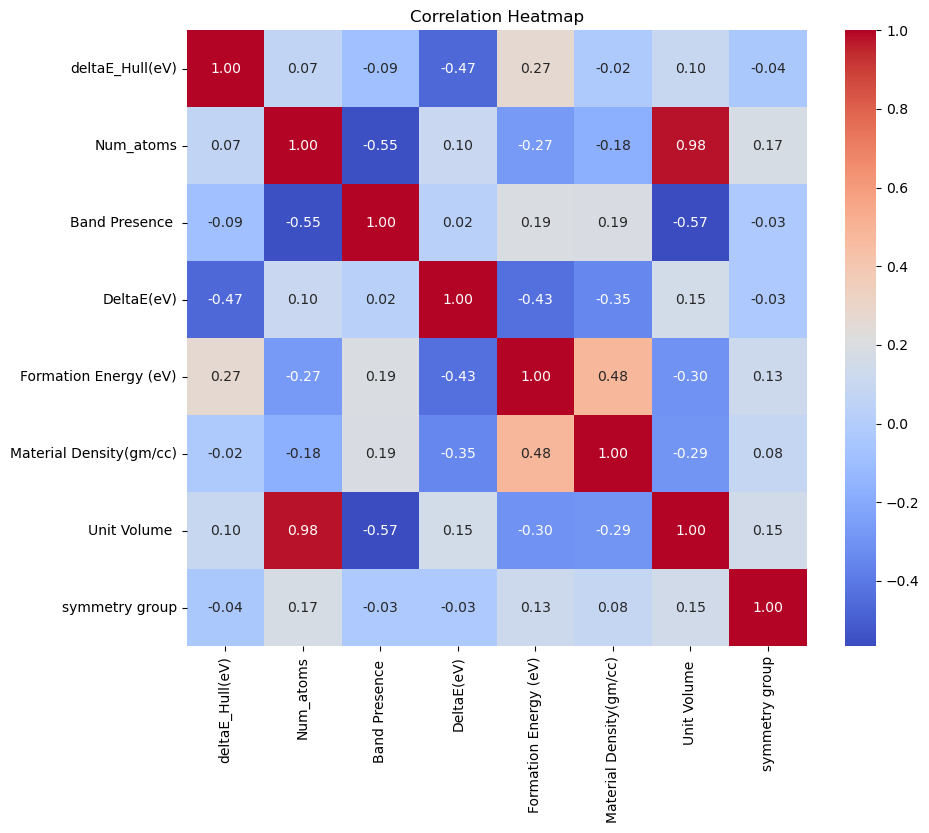

In [32]:
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()